In [136]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

In [137]:
df = pd.read_csv('clean_data.csv')

In [19]:
with pd.option_context('display.max_columns', None):
    display(df.head(10))

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Mult,MonthlyIncome/HomeDistance,DailyRate/HomeDistance,HourlyRate/HomeDistance,MonthlyRate/HomeDistance,JobSatisfaction/HomeDistance
0,41,1,1,1102,1,2,2,0,94,3,2,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,5993.000000,1102.000000,94.000000,19479.000000,4.000000
1,49,0,2,279,8,1,3,1,61,2,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,641.250000,34.875000,7.625000,3113.375000,0.250000
2,37,1,1,1373,2,2,4,1,92,2,1,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1045.000000,686.500000,46.000000,1198.000000,1.500000
3,33,0,2,1392,3,4,4,0,56,3,1,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,3,969.666667,464.000000,18.666667,7719.666667,1.000000
4,27,0,1,591,2,1,1,1,40,3,1,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,18,1734.000000,295.500000,20.000000,8316.000000,1.000000
5,32,0,2,1005,2,2,4,1,79,3,1,4,3068,11864,0,0,13,3,3,0,8,2,2,7,7,3,6,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1534.000000,502.500000,39.500000,5932.000000,2.000000
6,59,0,1,1324,3,3,3,0,81,4,1,1,2670,9964,4,1,20,4,1,3,12,3,2,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,890.000000,441.333333,27.000000,3321.333333,0.333333
7,30,0,1,1358,24,1,4,1,67,3,1,3,2693,13335,1,0,22,4,2,1,1,2,3,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,112.208333,56.583333,2.791667,555.625000,0.125000
8,38,0,2,216,23,3,4,1,44,2,3,3,9526,8787,0,0,21,4,2,0,10,2,3,9,7,1,8,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,414.173913,9.391304,1.913043,382.043478,0.130435
9,36,0,1,1299,27,3,3,1,94,3,2,3,5237,16577,6,0,13,3,2,2,17,3,2,7,7,7,7,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,42,193.962963,48.111111,3.481481,613.962963,0.111111


In [485]:
# df.drop(columns = 'Attrition').corrwith(df['Attrition']).sort_values(ascending = False)

In [138]:
df['Mult'] = df['YearsSinceLastPromotion'] * df['NumCompaniesWorked'] #
df['MonthlyIncome/HomeDistance'] = df['MonthlyIncome']/df['DistanceFromHome'] #
df['DailyRate/HomeDistance'] = df['DailyRate']/df['DistanceFromHome'] #
df['HourlyRate/HomeDistance'] = df['HourlyRate']/df['DistanceFromHome'] #
df['MonthlyRate/HomeDistance'] = df['MonthlyRate']/df['DistanceFromHome'] #
#df['MonthlyIncome/MonthlyRate'] = df['MonthlyIncome']/df['MonthlyRate']
#df['MonthlyIncome/DailyRate'] = df['MonthlyIncome']/df['DailyRate']
#df['MonthlyIncome/HourlyRate'] = df['MonthlyIncome']/df['HourlyRate']
df['JobSatisfaction/HomeDistance'] = df['JobSatisfaction']/df['DistanceFromHome'] #
#df['JobInvolvement/BusinessTravel'] = df['JobInvolvement']/(df['BusinessTravel']+1)
#df['MaritalStatus_Married*OverTime'] = df['MaritalStatus_Married']*df['OverTime'] #
#df['hz'] = df['RelationshipSatisfaction']*df['EnvironmentSatisfaction']*df['JobSatisfaction']

In [139]:
df.drop(np.where(df['JobRole_Research Director'] == 1)[0], inplace = True)

In [140]:
df.to_csv('clean_data_without_directors.csv', index = False)

In [5]:
# df = df[df['MonthlyIncome']<= 15000]

In [6]:
df.shape

(1390, 54)

## Приступим

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection, metrics

In [9]:
y = df['Attrition']
X = df.drop(columns = 'Attrition')

In [10]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, 
                                        test_size = 0.3, random_state = 16)

In [64]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# нормализация

## Сделаем функцию для построения матрицы ошибок (и еще несколько)

In [11]:
def build_matrix(y_test, predictions):
    tn,fn = metrics.confusion_matrix(y_test, predictions)[:,0]
    fp,tp = metrics.confusion_matrix(y_test, predictions)[:,1]
    matr = pd.DataFrame({'y_true = 1' : [tp,fn], 'y_true = 0' : [fp,tn]}, index = ['y_pred = 1','y_pred = 0'])
    display(matr)

In [12]:
def plot_scores(optimizer):
    scores=[]
    for i in range(len(optimizer.cv_results_['params'])):
        scores.append([optimizer.cv_results_['params'][i]['C'], 
                optimizer.cv_results_['mean_test_score'][i],
                optimizer.cv_results_['std_test_score'][i]])
    scores = np.array(scores)
    plt.semilogx(scores[:,0], scores[:,1])
    plt.fill_between(scores[:,0], scores[:,1]-scores[:,2], 
                                  scores[:,1]+scores[:,2], alpha=0.3)
    plt.show()

In [93]:
def thresh(y_test, probs, threshold):    
    preds = [1 if probs[i][1]> threshold else 0 for i in range(len(probs))]
    build_matrix(y_test, preds)
    return preds

# RandomForest

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

In [14]:
param_grid = {'n_estimators' : [10, 30, 50], 
              'criterion' : ['gini', 'entropy'], 
              'min_samples_split' : [2,5,10,15],
              'max_depth': [1,2,5,10],
              'min_samples_leaf': [1,2,5],
              }

rfc = RandomForestClassifier(random_state=16)

gs = GridSearchCV(rfc, param_grid, scoring = 'f1', cv = 5) #precision

In [15]:
gs.fit(X_train, y_train)

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=16,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'

In [16]:
gs.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 10}

In [17]:
predictions = gs.best_estimator_.predict(X_test)
print('accuracy = ', metrics.accuracy_score(y_test, predictions))
print('precision = ', metrics.precision_score(y_test, predictions)) 
print('recall = ', metrics.recall_score(y_test, predictions)) 
print('f1_score = ', metrics.f1_score(y_test, predictions))

accuracy =  0.8513189448441247
precision =  0.7647058823529411
recall =  0.18309859154929578
f1_score =  0.29545454545454547


In [18]:
build_matrix(y_test, predictions)

,y_true = 1,y_true = 0
y_pred = 1,13,4
y_pred = 0,58,342


0.5857689489538387


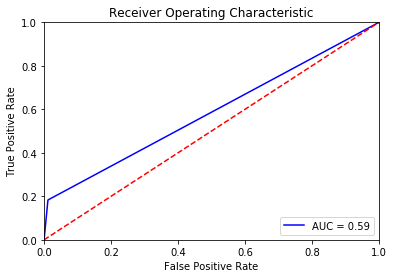

In [19]:
fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [119]:
# Без грид серча оптимальные параметры
rfc = RandomForestClassifier(criterion = 'gini', min_samples_split = 10, n_estimators = 50, random_state=16)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)

In [120]:
print('accuracy = ', metrics.accuracy_score(y_test, predictions))
print('PRECISION = ', metrics.precision_score(y_test, predictions)) 
print('recall = ', metrics.recall_score(y_test, predictions)) 
print('f1_score = ', metrics.f1_score(y_test, predictions))

accuracy =  0.8585131894484412
PRECISION =  0.875
recall =  0.19718309859154928
f1_score =  0.3218390804597701


In [22]:
build_matrix(y_test, predictions)

,y_true = 1,y_true = 0
y_pred = 1,14,2
y_pred = 0,57,344


In [76]:
probs = rfc.predict_proba(X_test)
thresh(y_test,probs,0.45)

,y_true = 1,y_true = 0
y_pred = 1,17,4
y_pred = 0,54,342


In [11]:
# Без грид серча оптимальные параметры с весами
rfc = RandomForestClassifier(criterion = 'gini', min_samples_split = 10, n_estimators = 50, class_weight='balanced', random_state=16)
rfc.fit(X_train,y_train)
predictions = rfc.predict(X_test)

In [12]:
print('accuracy = ', metrics.accuracy_score(y_test, predictions))
print('PRECISION = ', metrics.precision_score(y_test, predictions)) 
print('recall = ', metrics.recall_score(y_test, predictions)) 
print('f1_score = ', metrics.f1_score(y_test, predictions))

accuracy =  0.8561151079136691
PRECISION =  0.7894736842105263
recall =  0.2112676056338028
f1_score =  0.33333333333333337


In [15]:
build_matrix(y_test, predictions)

,y_true = 1,y_true = 0
y_pred = 1,15,4
y_pred = 0,56,342


In [16]:
pd.DataFrame(data = rfc.feature_importances_, index = X_train.columns).sort_values(0, ascending = False)

,0
MonthlyIncome,0.063411
OverTime,0.062154
Age,0.048697
DailyRate/HomeDistance,0.045473
HourlyRate/HomeDistance,0.041362
TotalWorkingYears,0.041155
YearsAtCompany,0.040970
MonthlyIncome/HomeDistance,0.036227
MonthlyRate/HomeDistance,0.035373
JobSatisfaction/HomeDistance,0.033392


# Сравнение моделей

## Сначала лес 

In [23]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [24]:
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

In [24]:
param_grid = {'n_estimators' : [10, 30, 50], 
              'criterion' : ['gini', 'entropy'], 
              'min_samples_split' : [2,5,10],
              'max_depth': [1,5,10],
              'min_samples_leaf': [1,5,10],
              }

rfc = RandomForestClassifier(random_state=16)

gs = GridSearchCV(rfc, param_grid, scoring = 'f1', cv = kf) #precision

In [25]:
gs.fit(X_train, y_train)

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=16,
                                              verbose=0, warm_start=False),
    

In [26]:
gs.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

In [27]:
predictions = gs.best_estimator_.predict(X_test)
print('accuracy = ', metrics.accuracy_score(y_test, predictions))
print('precision = ', metrics.precision_score(y_test, predictions)) 
print('recall = ', metrics.recall_score(y_test, predictions)) 
print('f1_score = ', metrics.f1_score(y_test, predictions))

accuracy =  0.8537170263788969
precision =  0.8125
recall =  0.18309859154929578
f1_score =  0.2988505747126437


In [28]:
build_matrix(y_test, predictions)

,y_true = 1,y_true = 0
y_pred = 1,13,3
y_pred = 0,58,343


## Логистическая регрессия 

In [25]:
from sklearn.linear_model import LogisticRegression

In [65]:
param_grid = {'C' : [10**-5, 10**-4, 10**-3, 10**-2, 10**-1, 10**0, 10*1]
              }

logreg = LogisticRegression(random_state=16)

gs = GridSearchCV(logreg, param_grid, scoring = 'f1', cv = kf) #precision

In [66]:
gs.fit(X_train, y_train)

B:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Sp

B:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
B:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
B:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
B:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
B:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=16, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=0)

In [67]:
gs.best_params_

{'C': 10}

In [68]:
predictions = gs.best_estimator_.predict(X_test)
print('accuracy = ', metrics.accuracy_score(y_test, predictions))
print('precision = ', metrics.precision_score(y_test, predictions)) 
print('recall = ', metrics.recall_score(y_test, predictions)) 
print('f1_score = ', metrics.f1_score(y_test, predictions))

accuracy =  0.8609112709832134
precision =  0.6511627906976745
recall =  0.39436619718309857
f1_score =  0.4912280701754386


In [69]:
build_matrix(y_test, predictions)

,y_true = 1,y_true = 0
y_pred = 1,28,15
y_pred = 0,43,331


In [70]:
fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.6755067980135147

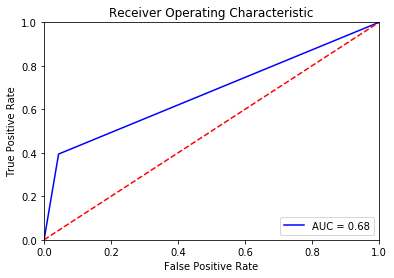

In [71]:
fpr, tpr, threshold = roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [64]:
logreg = LogisticRegression(C = 10, random_state=16)
logreg.fit(X_train,y_train)
predictions = logreg.predict(X_test)
print('accuracy = ', metrics.accuracy_score(y_test, predictions))
print('precision = ', metrics.precision_score(y_test, predictions)) 
print('recall = ', metrics.recall_score(y_test, predictions)) 
print('f1_score = ', metrics.f1_score(y_test, predictions))
build_matrix(y_test, predictions)

accuracy =  0.8609112709832134
precision =  0.6511627906976745
recall =  0.39436619718309857
f1_score =  0.4912280701754386


B:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,y_true = 1,y_true = 0
y_pred = 1,28,15
y_pred = 0,43,331


In [71]:
probs = logreg.predict_proba(X_test)
thresh(y_test,probs,0.60)

,y_true = 1,y_true = 0
y_pred = 1,16,5
y_pred = 0,55,341


## Ridge 

In [35]:
from sklearn.linear_model import RidgeClassifier

In [36]:
ridge = RidgeClassifier(random_state = 16)
ridge.fit(X_train,y_train)
predictions = ridge.predict(X_test)
print('accuracy = ', metrics.accuracy_score(y_test, predictions))
print('precision = ', metrics.precision_score(y_test, predictions)) 
print('recall = ', metrics.recall_score(y_test, predictions)) 
print('f1_score = ', metrics.f1_score(y_test, predictions))

accuracy =  0.8537170263788969
precision =  0.7777777777777778
recall =  0.19718309859154928
f1_score =  0.3146067415730337


In [37]:
build_matrix(y_test, predictions)

,y_true = 1,y_true = 0
y_pred = 1,14,4
y_pred = 0,57,342


## AdaBoost

In [44]:
from sklearn.ensemble import AdaBoostClassifier

In [46]:
ada = AdaBoostClassifier(random_state = 16)
ada.fit(X_train,y_train)
predictions = ada.predict(X_test)
print('accuracy = ', metrics.accuracy_score(y_test, predictions))
print('precision = ', metrics.precision_score(y_test, predictions)) 
print('recall = ', metrics.recall_score(y_test, predictions)) 
print('f1_score = ', metrics.f1_score(y_test, predictions))
build_matrix(y_test, predictions)

accuracy =  0.8633093525179856
precision =  0.6666666666666666
recall =  0.39436619718309857
f1_score =  0.495575221238938


,y_true = 1,y_true = 0
y_pred = 1,28,14
y_pred = 0,43,332


In [47]:
probs = ada.predict_proba(X_test)

In [53]:
probs[1:10]

array([[0.49856543, 0.50143457],
       [0.50958934, 0.49041066],
       [0.51467142, 0.48532858],
       [0.52677674, 0.47322326],
       [0.51416795, 0.48583205],
       [0.49254718, 0.50745282],
       [0.51908543, 0.48091457],
       [0.5002189 , 0.4997811 ],
       [0.51790364, 0.48209636]])

In [63]:
thresh(y_test,probs,0.51)

,y_true = 1,y_true = 0
y_pred = 1,7,1
y_pred = 0,64,345


## GradientBoostingClassifier 

In [77]:
from sklearn.ensemble import GradientBoostingClassifier

In [98]:
param_grid = {'n_estimators' : [20, 50, 100, 200],
              'learning_rate' : [0.001,0.01,0.1,0.5,1],
              'min_samples_split' : [2,5,10],
              'min_samples_leaf' : [1,2,5]
              }

gbc = GradientBoostingClassifier(random_state=16)

gs = GridSearchCV(gbc, param_grid, scoring = 'f1', cv = kf) #precision
gs.fit(X_train,y_train)
gs.best_params_

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
B:\Programs\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: 

{'learning_rate': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [128]:
gbc = GradientBoostingClassifier(random_state = 16)
gbc.fit(X_train,y_train)
predictions = gbc.predict(X_test)
print('accuracy = ', metrics.accuracy_score(y_test, predictions))
print('precision = ', metrics.precision_score(y_test, predictions)) 
print('recall = ', metrics.recall_score(y_test, predictions)) 
print('f1_score = ', metrics.f1_score(y_test, predictions))
build_matrix(y_test, predictions)

accuracy =  0.8752997601918465
precision =  0.8275862068965517
recall =  0.3380281690140845
f1_score =  0.48000000000000004


,y_true = 1,y_true = 0
y_pred = 1,24,5
y_pred = 0,47,341


In [85]:
probs = gbc.predict_proba(X_test)
thresh(y_test, probs, 0.60)

,y_true = 1,y_true = 0
y_pred = 1,16,1
y_pred = 0,55,345


In [132]:
probs = gbc.predict_proba(X_test)
predictions = thresh(y_test, probs, 0.55)

,y_true = 1,y_true = 0
y_pred = 1,19,2
y_pred = 0,52,344


In [141]:
17000000*0.26

4420000.0

In [133]:
print('accuracy = ', metrics.accuracy_score(y_test, predictions))
print('precision = ', metrics.precision_score(y_test, predictions)) 
print('recall = ', metrics.recall_score(y_test, predictions)) 
print('f1_score = ', metrics.f1_score(y_test, predictions))
build_matrix(y_test, predictions)

accuracy =  0.8705035971223022
precision =  0.9047619047619048
recall =  0.2676056338028169
f1_score =  0.41304347826086957


,y_true = 1,y_true = 0
y_pred = 1,19,2
y_pred = 0,52,344


In [135]:
pd.DataFrame(data = gbc.feature_importances_, index = X_train.columns).sort_values(0, ascending = False)

,0
OverTime,0.118608
MonthlyIncome,0.081864
JobSatisfaction/HomeDistance,0.064024
EnvironmentSatisfaction,0.059595
HourlyRate/HomeDistance,0.041818
NumCompaniesWorked,0.035514
TotalWorkingYears,0.033487
DailyRate,0.033300
StockOptionLevel,0.033143
DailyRate/HomeDistance,0.032107


In [90]:
predictions = thresh(y_test, probs, 0.60)

,y_true = 1,y_true = 0
y_pred = 1,16,1
y_pred = 0,55,345


In [94]:
print('accuracy = ', metrics.accuracy_score(y_test, predictions))
print('precision = ', metrics.precision_score(y_test, predictions)) 
print('recall = ', metrics.recall_score(y_test, predictions)) 
print('f1_score = ', metrics.f1_score(y_test, predictions))
build_matrix(y_test, predictions)

accuracy =  0.8657074340527577
precision =  0.9411764705882353
recall =  0.22535211267605634
f1_score =  0.36363636363636365


,y_true = 1,y_true = 0
y_pred = 1,16,1
y_pred = 0,55,345


In [101]:
from sklearn.neighbors import KNeighborsClassifier

In [113]:
knn = KNeighborsClassifier(n_neighbors=11)
knn.fit(X_train,y_train)
predictions = knn.predict(X_test)
print('accuracy = ', metrics.accuracy_score(y_test, predictions))
print('precision = ', metrics.precision_score(y_test, predictions)) 
print('recall = ', metrics.recall_score(y_test, predictions)) 
print('f1_score = ', metrics.f1_score(y_test, predictions))
build_matrix(y_test, predictions)

accuracy =  0.8345323741007195
precision =  0.6
recall =  0.08450704225352113
f1_score =  0.14814814814814814


,y_true = 1,y_true = 0
y_pred = 1,6,4
y_pred = 0,65,342


In [114]:
from sklearn.ensemble import BaggingClassifier

In [115]:
bagg = BaggingClassifier(random_state = 16)
bagg.fit(X_train,y_train)
predictions = bagg.predict(X_test)
print('accuracy = ', metrics.accuracy_score(y_test, predictions))
print('precision = ', metrics.precision_score(y_test, predictions)) 
print('recall = ', metrics.recall_score(y_test, predictions)) 
print('f1_score = ', metrics.f1_score(y_test, predictions))
build_matrix(y_test, predictions)

accuracy =  0.8441247002398081
precision =  0.6153846153846154
recall =  0.22535211267605634
f1_score =  0.3298969072164949


,y_true = 1,y_true = 0
y_pred = 1,16,10
y_pred = 0,55,336


In [118]:
bagg = BaggingClassifier(base_estimator=gbc, random_state = 16)
bagg.fit(X_train,y_train)
predictions = bagg.predict(X_test)
print('accuracy = ', metrics.accuracy_score(y_test, predictions))
print('precision = ', metrics.precision_score(y_test, predictions)) 
print('recall = ', metrics.recall_score(y_test, predictions)) 
print('f1_score = ', metrics.f1_score(y_test, predictions))
build_matrix(y_test, predictions)

accuracy =  0.86810551558753
precision =  0.8333333333333334
recall =  0.28169014084507044
f1_score =  0.4210526315789474


,y_true = 1,y_true = 0
y_pred = 1,20,4
y_pred = 0,51,342


In [121]:
bagg = BaggingClassifier(base_estimator=rfc, random_state = 16)
bagg.fit(X_train,y_train)
predictions = bagg.predict(X_test)
print('accuracy = ', metrics.accuracy_score(y_test, predictions))
print('precision = ', metrics.precision_score(y_test, predictions)) 
print('recall = ', metrics.recall_score(y_test, predictions)) 
print('f1_score = ', metrics.f1_score(y_test, predictions))
build_matrix(y_test, predictions)

accuracy =  0.8513189448441247
precision =  0.9090909090909091
recall =  0.14084507042253522
f1_score =  0.24390243902439027


,y_true = 1,y_true = 0
y_pred = 1,10,1
y_pred = 0,61,345


## Пошла визуализация 

Поменяем Attrition на Yes и No для красоты

In [172]:
df['Attrition'].replace([1,0], ['Yes', 'No'], inplace = True)

In [ ]:
df.groupby(['Equipment'])[['BodyweightKg', 'TotalKg']].mean().plot.bar(figsize = (14,5), stacked = True)

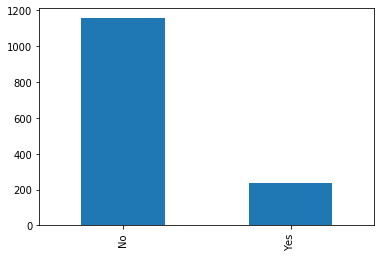

In [148]:
df['Attrition'].value_counts().plot.bar() # дизбаланс классов

In [28]:
df.groupby(['OverTime'])[['Attrition']].sum()

,Attrition
OverTime,
0,109
1,126


In [25]:
df[(df['OverTime'] == 1) & (df['Attrition'] == 1)].shape

(126, 54)

In [26]:
df[(df['OverTime'] == 1) & (df['Attrition'] == 0)].shape

(267, 54)

In [32]:
df[df['OverTime'] == 1].groupby(['Attrition'])[['OverTime']].sum() # из 393 перерабатывающих сотрудников увольняется 
                                                                                    # примерно треть

,OverTime
Attrition,
0,267
1,126


In [33]:
126/393

0.32061068702290074

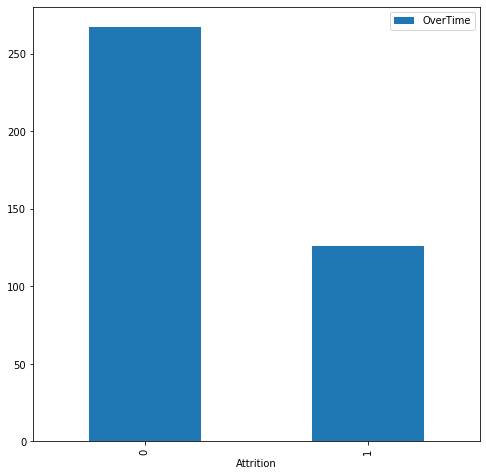

In [41]:
df[df['OverTime'] == 1].groupby(['Attrition'])[['OverTime']].sum().plot.bar(figsize = (8,8)) # из перерабатывающих
                                                                                    # сколько уволилось, а сколько нет.

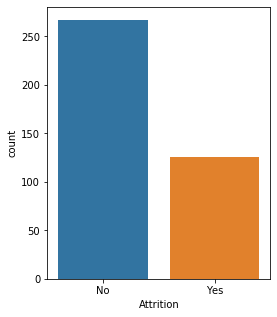

In [147]:
fig = plt.figure(figsize=(4,5))
sns.countplot(df[df['OverTime'] == 1]['Attrition'], order = ['No', 'Yes']) # из перерабатывающих сколько уволилось, а сколько нет.


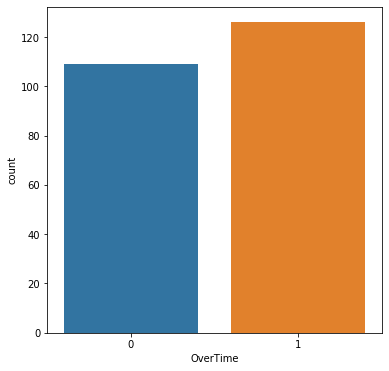

In [88]:
fig = plt.figure(figsize=(6,6))
sns.countplot(df[df['Attrition'] == 1]['OverTime']) # из тех кто уволился кто перерабатывал, а кто нет
# pandas bar = seaborn countplot

### Montly Income 

In [45]:
df[df['Attrition'] == 1]['MonthlyIncome'].mean()

4662.765957446809

In [50]:
df[df['Attrition'] == 1]['MonthlyIncome'].median()

3172.0

In [46]:
df[df['Attrition'] == 0]['MonthlyIncome'].mean()

6217.207792207792

In [51]:
df[df['Attrition'] == 0]['MonthlyIncome'].median()

4936.0

Те кто не увольняется в среднем зарабатывают больше

In [47]:
df[(df['Attrition'] == 1) & (df['OverTime'] == 1)]['MonthlyIncome'].mean()

4574.3650793650795

In [52]:
df[(df['Attrition'] == 1) & (df['OverTime'] == 1)]['MonthlyIncome'].median()

2931.0

In [49]:
df[(df['Attrition'] == 0) & (df['OverTime'] == 1)]['MonthlyIncome'].mean()

6665.681647940075

In [53]:
df[(df['Attrition'] == 0) & (df['OverTime'] == 1)]['MonthlyIncome'].median()

5410.0

Деньги помогают удержать сотрудников, т.к.  люди которые перерабатывают, но получают больше денег, уходят реже


### Age 

In [54]:
df[df['Attrition'] == 1]['Age'].mean()

33.47234042553192

In [56]:
df[df['Attrition'] == 1]['Age'].median()

31.0

In [55]:
df[df['Attrition'] == 0]['Age'].mean()

37.135930735930735

In [57]:
df[df['Attrition'] == 0]['Age'].median()

36.0

Есть небольшая разница в возрасте. Медианный возраст человека который уволился - 31 год, который не уволился - 36 лет

In [69]:
import seaborn as sns

In [77]:
df[df['Attrition'] == 1]['OverTime'].value_counts()

1    126
0    109
Name: OverTime, dtype: int64

In [115]:
df['AgeCategory'] = np.where((df['Age']>= 18) & (df['Age'] < 25),'18-24', 
                             np.where((df['Age']>= 25) & (df['Age'] < 32),'25-31', 
                             np.where((df['Age']>= 32) & (df['Age'] < 39),'32-38', 
                             np.where((df['Age']>= 39) & (df['Age'] < 46),'39-45',
                             np.where((df['Age']>= 46) & (df['Age'] < 53),'46-52',
                             np.where((df['Age']>= 53) & (df['Age'] < 60),'53-59',
                             np.where(df['Age']>= 60,'>=60','None')))))))

In [105]:
df[df['Age'] == 23][['Age', 'AgeCategory']]

,Age,AgeCategory
86,23,18-25
345,23,18-25
516,23,18-25
550,23,18-25
565,23,18-25
585,23,18-25
910,23,18-25
1082,23,18-25
1127,23,18-25
1201,23,18-25


In [113]:
df[['Age', 'AgeCategory']]

,Age,AgeCategory
0,41,39-46
1,49,46-53
2,37,32-39
3,33,32-39
4,27,25-32
...,...,...
1465,36,32-39
1466,39,39-46
1467,27,25-32
1468,49,46-53


In [117]:
df[df['Age']>=60]

,Age,Attrition,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,...,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Mult,MonthlyIncome/HomeDistance,DailyRate/HomeDistance,HourlyRate/HomeDistance,MonthlyRate/HomeDistance,JobSatisfaction/HomeDistance,AgeCategory
411,60,0,1,422,7,3,1,0,41,3,...,0,1,0,55,2795.142857,60.285714,5.857143,550.571429,0.142857,>=60
427,60,0,2,1499,28,3,3,0,80,2,...,0,1,0,52,366.642857,53.535714,2.857143,101.607143,0.035714,>=60
536,60,0,1,1179,16,4,1,1,84,3,...,0,0,1,16,337.812500,73.687500,5.250000,745.250000,0.062500,>=60
879,60,0,1,696,7,4,2,1,52,4,...,1,0,0,0,745.714286,99.428571,7.428571,1556.142857,0.571429,>=60
1209,60,0,1,370,1,4,3,1,92,1,...,1,0,0,0,10883.000000,370.000000,92.000000,20467.000000,4.000000,>=60


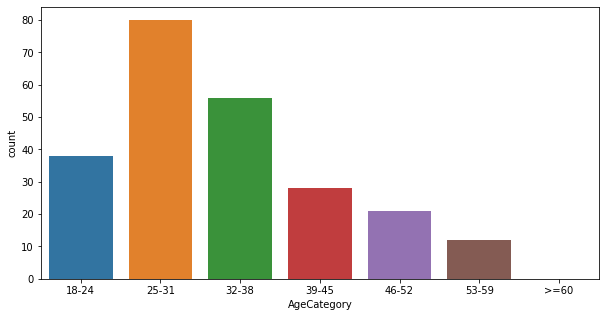

In [120]:
fig = plt.figure(figsize=(10,5))
sns.countplot(df[df['Attrition'] == 1]['AgeCategory'], order = ['18-24','25-31','32-38','39-45','46-52','53-59','>=60'])

Сколько людей в самой опасной возрастной категории уволились из-за переработок

In [124]:
df[(df['AgeCategory'] == '25-31')&(df['Attrition'] == 1)]['OverTime'].value_counts()

0    41
1    39
Name: OverTime, dtype: int64

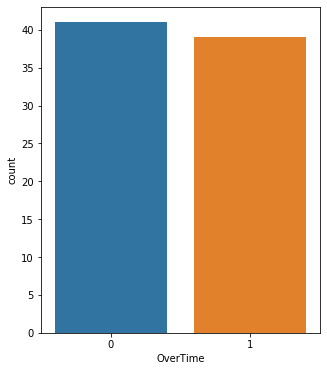

In [127]:
fig = plt.figure(figsize=(5,6))
sns.countplot(df[(df['AgeCategory'] == '25-31')&(df['Attrition'] == 1)]['OverTime'])

In [128]:
df[(df['AgeCategory'] == '25-31')&(df['OverTime'] == 1)]['Attrition'].value_counts()

0    54
1    39
Name: Attrition, dtype: int64

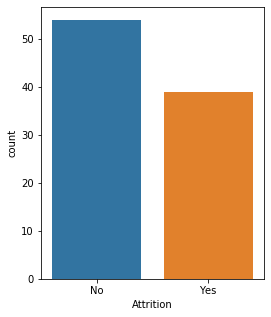

In [144]:
fig = plt.figure(figsize=(4,5))
sns.countplot(df[(df['AgeCategory'] == '25-31')&(df['OverTime'] == 1)]['Attrition']) # сколько из перерабатывающих уволилис

In [131]:
39/(54+39)

0.41935483870967744

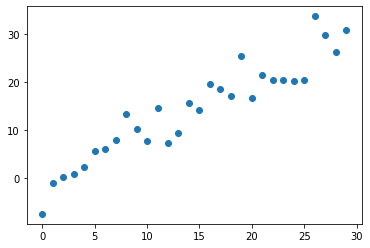

In [94]:
plt.scatter(np.arange(30), np.arange(30)+3*np.random.randn(30))

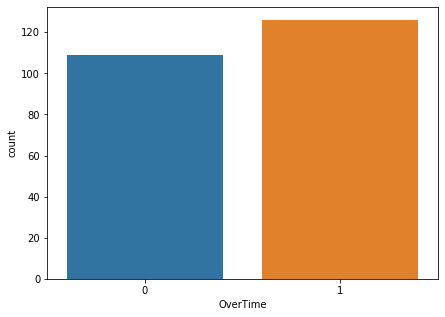

In [91]:
fig = plt.figure(figsize=(7,5))
sns.countplot(df[df['Attrition'] == 1]['OverTime']) # из тех кто уволился кто перерабатывал, а кто нет
# pandas bar = seaborn countplot

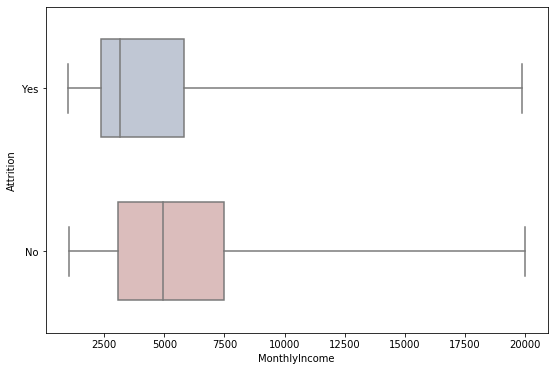

In [152]:
fig = plt.figure(figsize=(9,6))
sns.boxplot(x="MonthlyIncome", y="Attrition", data=df,
            whis=[0, 100], width=.6, palette="vlag")

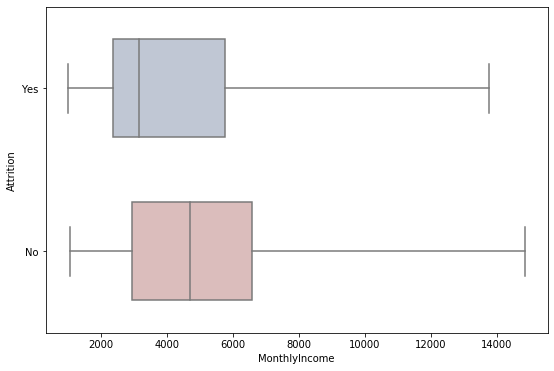

In [155]:
fig = plt.figure(figsize=(9,6))
sns.boxplot(x="MonthlyIncome", y="Attrition", data=df[df['MonthlyIncome']<=15000], #уберем тех кто дохера зарабатывает
            whis=[0, 100], width=.6, palette="vlag")

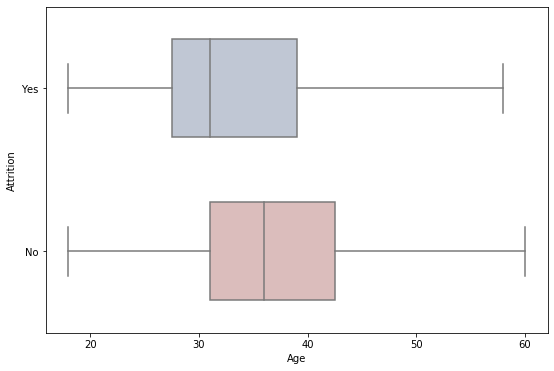

In [153]:
fig = plt.figure(figsize=(9,6))
sns.boxplot(x="Age", y="Attrition", data=df,
            whis=[0, 100], width=.6, palette="vlag")

In [529]:
y_test.shape

(441,)

In [516]:
import seaborn as sns

In [513]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

array([[373,   2],
       [ 59,   7]], dtype=int64)

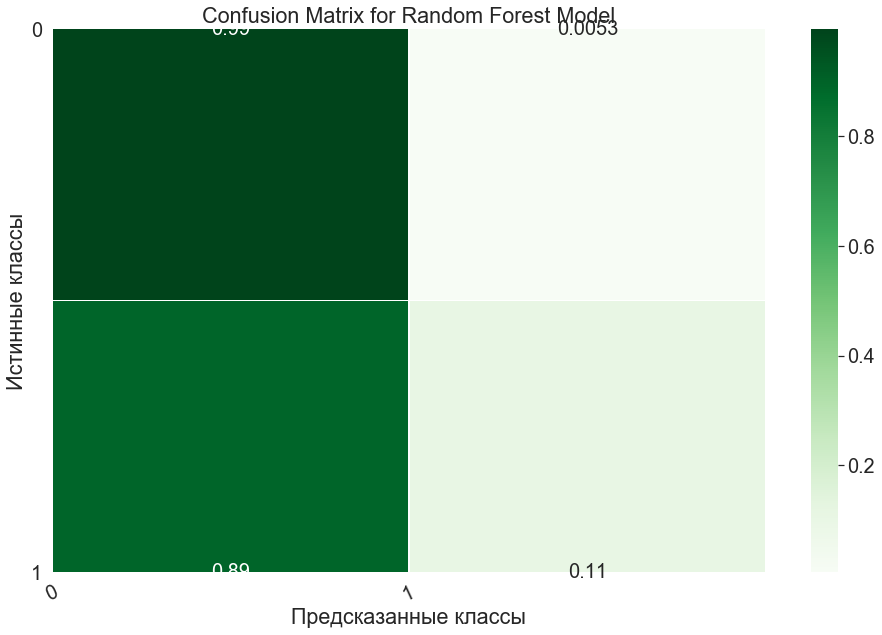

In [526]:
# так же матрица в процентах и более изящном виде
matrix = confusion_matrix(y_test, predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,10))
sns.set(font_scale=1.8)
sns.heatmap(matrix, annot=True, annot_kws={'size':20},
            cmap=plt.cm.Greens, linewidths=0.5)

# Add labels to the plot
class_names = ['0', '1']                 # !!!!!! указать названия классов!
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Предсказанные классы')
plt.ylabel('Истинные классы')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()